In [1]:
import copy
from enum import Enum
import drjit as dr
import mitsuba as mi
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
from tqdm import tqdm
from typing import List

from mimt import *

mi.set_variant("cuda_ad_rgb")

assert (mi.MI_VERSION_MAJOR == 3) and (mi.MI_VERSION_MINOR < 5), "This notebook requires reparametrization (deprecated since Mitsuba 3.5.0)"

In [2]:
scene = mi.load_file('scenes/cbox.xml')
params = mi.traverse(scene)

import mitsuba.python.ad.reparam as reparam_
import mitsuba.python.ad.integrators.common as common_

def reparam(scene: mi.Scene,
            rng: mi.PCG32,
            params,
            ray: mi.Ray3f,
            depth: mi.UInt32,
            active: mi.Bool):
    """
    Helper function to reparameterize rays internally and within ADIntegrator
    """
    return mi.ad.reparameterize_ray(scene, rng, params, ray,
                                    num_rays=16,
                                    kappa=1e5,
                                    exponent=3,
                                    antithetic=False,
                                    unroll=False,
                                    active=active)

reparametrize_rays = common_._ReparamWrapper(scene, params, reparam, 1, 0)

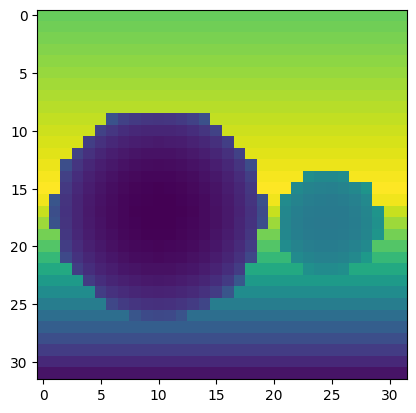

In [3]:
tx = mi.Float(0.)
dr.enable_grad(tx)

# Camera origin in world space
cam_origin = mi.Point3f(tx, 1, 3)

# Camera view direction in world space
cam_dir = dr.normalize(mi.Vector3f(0, -0.5, -1))

# Camera width and height in world space
cam_width  = 1.7
cam_height = 1.7

# Image pixel resolution
image_res = [32, 32]

# Construct a grid of 2D coordinates
x, y = dr.meshgrid(
    dr.linspace(mi.Float, -cam_width  / 2,   cam_width / 2, image_res[0]),
    dr.linspace(mi.Float, -cam_height / 2,  cam_height / 2, image_res[1])
)

# Ray origin in local coordinates
ray_origin_local = mi.Vector3f(x, y, 0)

# Ray origin in world coordinates
ray_origin = mi.Frame3f(cam_dir).to_world(ray_origin_local) + cam_origin

ray = mi.Ray3f(o=ray_origin, d=cam_dir)

ray.d, det = reparametrize_rays(ray, 0)

si = scene.ray_intersect(ray)

#dr.backward_from(si.t)
dr.forward_from(tx)
dr.grad(si.p)

plt.imshow(si.t.numpy().reshape(*image_res))

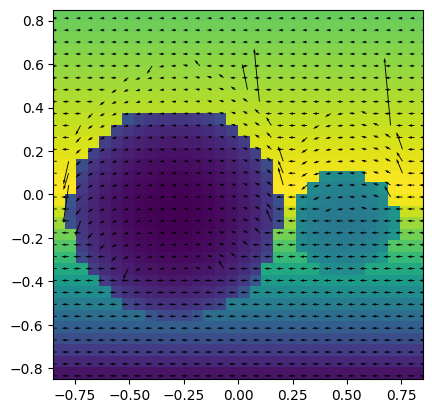

In [4]:
ss = 1
px = x.numpy().reshape(*image_res) + 0.5 / image_res[1]
py = y.numpy().reshape(*image_res) + 0.5 / image_res[0]
uv = dr.grad(si.p).numpy()[:, :2].reshape(*image_res, 2)

extent=(-cam_width  / 2, cam_width / 2, -cam_height / 2,  cam_height / 2)
fig, ax = plt.subplots(1, 1)
ax.set_xlim(extent[0], extent[1])
ax.set_ylim(extent[2], extent[3])
ax.imshow(si.t.numpy().reshape(*image_res), extent=(-cam_width  / 2, cam_width / 2, -cam_height / 2,  cam_height / 2))
ax.quiver(px[::ss, ::ss].ravel(), py[::ss, ::ss].ravel(), uv[::ss, ::ss, 0].ravel(), uv[::ss, ::ss, 1].ravel())